# Community Housing survey Project (CHP) EDA
This notebook is designed to do exploratory data analysis (EDA) for the 2020 PhD-Community Initiative Housing
Survey dataset

Coded by Josh Moskowitz in February 2020

---




Import the relevant libraries and other setup

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Setup
%matplotlib inline
pd.set_option('display.max_columns', None)

Import survey data

In [26]:
survey = pd.read_excel('F:/Users/Josh/Dropbox/PhD-CI/KCH_03082020_90.xlsx',index_col=None,header=0)
# survey = pd.read_excel('C:/Users/Josh/Desktop/Dropbox/PhD-CI/KCH_01312020_70.xlsx',index_col=None,header=0)
questions = survey.iloc[0][:] # grab question wording and store for later

## Cleanup survey data

Remove unecessary rows and cols

In [27]:
survey.drop(index=[0,1],inplace=True) # remove first 2 rows
# Remove any irrelevant or personally idenitifying columns
survey.drop(labels=['Status','IPAddress','RecipientLastName','RecipientFirstName','RecipientEmail',
                    'ExternalReference','LocationLatitude','LocationLongitude','DistributionChannel',
                    'UserLanguage','info','consent'],axis=1,inplace=True)
survey.reset_index(drop=True, inplace=True) # reset index

Remove Whitespace and weird characters

In [28]:
def cleanDataFrame(obj):
    "Return a modified string"
    if isinstance(obj, str): # if object is a string
        return obj.replace("â€™", "'").strip() # fix apostrophes and remove trailing whitespace
    else:
        return obj

survey = survey.applymap(cleanDataFrame)

Function that will strip commas and split string when a person gave multiple responses

In [29]:
def cleanAndSplit(string):
    "Return a list of strings split by comma"
    
    # remove commas from one of the possible survey responses
    # "I need to be closer to work, childcare, or social/health support services"
    if "I need to be closer to work" in string:
        idx1 = string.find("childcare") - 2
        idx2 = string.find(" or ") - 1
        cleanString = string[:idx1] + string[idx1:idx2].replace(',','') + string[idx2+1:]
    else:
        cleanString = string

    return cleanString.split(',')

Function that will recode the employment column to only include one employment type

In [30]:
def recodeEmploy(row):
    "Return a Pandas row object with modified employment data"
    
    if isinstance(row.employment,str):
        listStatus = cleanAndSplit(row.employment)
        # we don't care if students are employed or not
        if 'Student' in listStatus:
            row.employment = 'Student'
        # we don't care if retirees are employed or not
        elif 'Retired' in listStatus:
            row.employment = 'Retired'
        else:
            row.employment = listStatus[0]
    return row
survey = survey.apply(recodeEmploy,axis='columns')

# Helper functions

In [31]:
def SepResp(col):
    "Return a Pandas series containing all strings present across this col"
    lst = []
    for i in col:
        if isinstance(i,str):
            lst.append(cleanAndSplit(i)) # Append responses to List

    lst = [item for sublist in lst for item in sublist] # flatten list
    return pd.Series(lst,index=None) # convert to series

This function will automatically generate plotting of response frequency or percentage for desired cols, with the option to group by a second variable

In [32]:
def plotResp(col,questions,order=None,normalize=False,title=None):
    "Creates a horizontal bar graph showing responses for this col"
    if title != None:
        title = title
    elif "Selected Choice" in questions[col.name]:
        title = questions[col.name][0:-17] # remove this extra text
    else:
        title = questions[col.name]
    if 'why_move' in col.name:
        col = SepResp(col)
    ax = col.value_counts(normalize=normalize).reindex(order).plot(kind='barh',title=title)
    if normalize:
        plt.draw()
        ax.set_xlabel('Percentage (%)')
        labels = ax.get_xticklabels() # Get locations and labels
        labels = [round(float(label.get_text())*100) for label in labels] # convert to int
        ax.set_xticklabels(labels)
    else:
        ax.set_xlabel('Count')
    if normalize:
        print(col.value_counts(normalize=normalize).reindex(order)*100)
    else:
        print(col.value_counts(normalize=normalize).reindex(order)) 
    return ax

In [33]:
def plotGroupBy(survey,col,groupBy,title,order=None,normalize=False,transpose=False,legendXLoc=1):
    "Creates a horizontal bar graph showing grouped responses for this col by the groupBy variable"
    # Group by subsidy, convert to dataframe, and rename data col
    data = survey.groupby([groupBy])[col].value_counts(
        normalize=normalize).to_frame().rename(columns={col:'resp'})
    data = pd.pivot_table(data, index = col, columns = groupBy, 
        values = 'resp').reindex(order)
    if transpose:
        data = data.transpose()
    ax = data.plot(kind = 'barh',title=title)    
    if normalize:
        plt.draw()
        ax.set_xlabel('Percentage (%)')
        labels = ax.get_xticklabels() # Get locations and labels
        labels = [round(float(label.get_text())*100) for label in labels] # convert to int
        ax.set_xticklabels(labels)
    else:
        ax.set_xlabel('Count')
    ax.legend(loc='upper right', bbox_to_anchor=(legendXLoc, 1)) # move legend to outside axes
    return data

In [34]:
def plotGroupByWhyMove(survey,groupBy,whyMoveNames,groupByNames,title,transpose=False,legendXLoc=2.2):
    
    # Create dataframe and get a prop for each category
    df_forStacked = pd.DataFrame(data=None,index=whyMoveNames,columns=None)
    
    groupByCounts = survey[groupBy].value_counts(normalize=True).reindex(groupByNames)
    
    for col in groupByNames: # for each groupBy response
        # generate a col to be added to the df
        colItem = SepResp(survey.loc[survey[groupBy] == col].why_move).value_counts(
        ).reindex(whyMoveNames).fillna(value=0)
        if transpose:
            newCol = colItem.map(lambda i: (i / colItem.sum()) * groupByCounts.loc[col]).to_frame() # convert to percentage of living arr
        else: # just store raw count for later average across row
            newCol = colItem.to_frame()
        newCol = newCol.rename(columns={0:col}) # rename col with actual to append to df
        df_forStacked = pd.concat([df_forStacked,newCol],axis=1)
        
    if transpose:
        df_forStacked = df_forStacked.transpose()
    else: # average across row and adjust by why move percentage
        whyMoveCounts = SepResp(survey.why_move).value_counts(normalize=True).reindex(whyMoveNames)
        df_forStacked = df_forStacked.apply(lambda row: (row / row.sum()) * whyMoveCounts.loc[row.name],axis=1,result_type='broadcast')    
        
    
    # Plotting
    ax = df_forStacked.plot(kind='barh',stacked=True,title=title)
    plt.draw()
    ax.set_xlabel('Percentage (%)')
    labels = ax.get_xticklabels() # Get locations and labels
    labels = [round(float(label.get_text())*100) for label in labels] # convert to int
    ax.set_xticklabels(labels);
    ax.legend(loc='upper right', bbox_to_anchor=(legendXLoc, 1)) # move legend to outside axes
    return df_forStacked

In [35]:
survey.columns # check col names for plotting

Index(['StartDate', 'EndDate', 'Progress', 'Duration (in seconds)', 'Finished',
       'RecordedDate', 'ResponseId', 'num_applied', 'num_applied_explain',
       'num_applied_explain_2_TEXT', 'num_applied_explain_3_TEXT',
       'private_housing', 'current_living_arr', 'current_living_arr_6_TEXT',
       'why_move', 'why_move_7_TEXT', 'subsidy', 'employment', 'income_stable',
       'utilities', 'debt', 'mental_health', 'substance_use', 'gender', 'age',
       'fam_status', 'fam_status_5_TEXT', 'first_nation', 'vis_minority',
       'can_residency', 'can_residency_3_TEXT'],
      dtype='object')

## Demographic Data

### Gender

Female                                                       72.043011
Male                                                         23.655914
I prefer not to disclose information concerning my gender     3.225806
I don't identify within the gender binary                     1.075269
Name: gender, dtype: float64


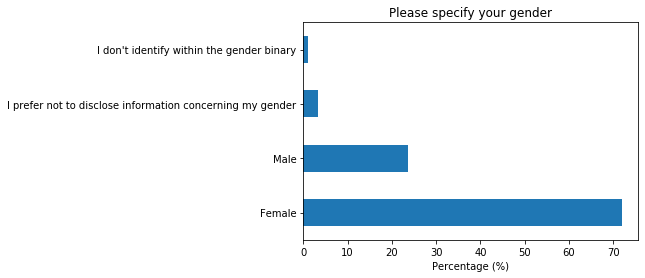

In [36]:
plotResp(survey['gender'],questions,normalize=True) # using helper function

### Age

25 - 65     70.967742
Over 65     18.279570
Under 25    10.752688
Name: age, dtype: float64


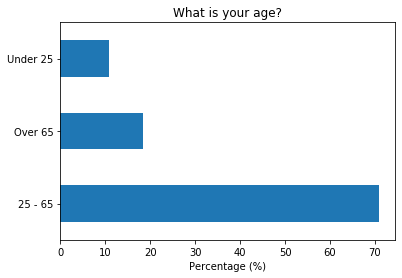

In [37]:
plotResp(survey['age'],questions,normalize=True)

### Family Status

Single no dependents         54.838710
Single with dependents       26.881720
Couple with dependents        9.677419
Other:                        5.376344
Couple without dependents     3.225806
Name: fam_status, dtype: float64


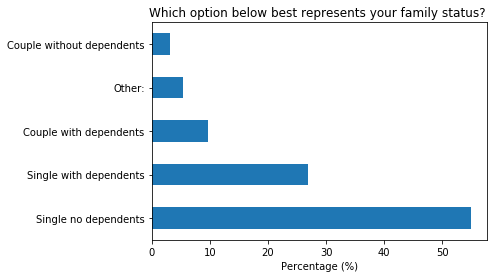

In [38]:
plotResp(survey['fam_status'],questions,normalize=True)

### Do you identify as First Nation (Status/Non-Status), Métis, or Inuk (Inuit)?

No                   83.870968
Yes                   8.602151
Prefer not to say     7.526882
Name: first_nation, dtype: float64


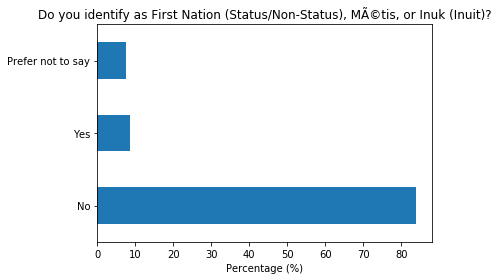

In [39]:
plotResp(survey['first_nation'],questions,normalize=True)

### Do you identify as a visible minority?

No                   84.946237
Yes                   8.602151
Prefer not to say     6.451613
Name: vis_minority, dtype: float64


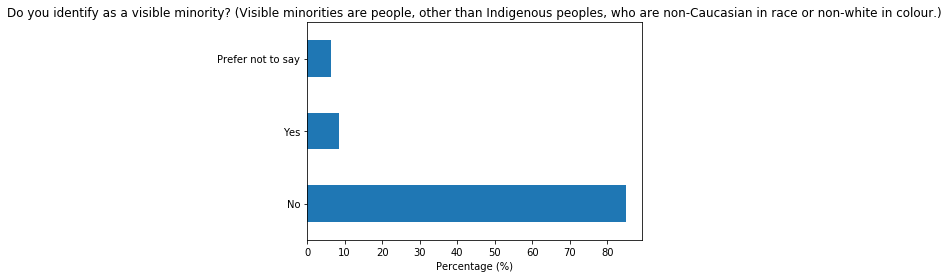

In [40]:
plotResp(survey['vis_minority'],questions,normalize=True)

### Residency Status

Canadian Citizen      93.548387
Other:                 3.225806
Permanent Resident     3.225806
Name: can_residency, dtype: float64


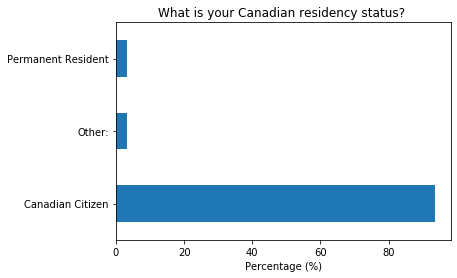

In [41]:
plotResp(survey['can_residency'],questions,normalize=True)

### Employment Status

Unemployed            43.010753
Retired               27.956989
Part time employed    15.053763
Student                8.602151
Full time employed     5.376344
Name: employment, dtype: float64


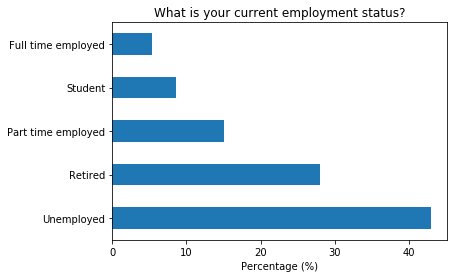

In [42]:
plotResp(survey['employment'],questions,normalize=True)

### Employment Status by age

age,25 - 65,Over 65,Under 25
employment,,,
Full time employed,0.075758,NaN,NaN
Part time employed,0.181818,0.058824,0.1
Retired,0.151515,0.941176,NaN
Student,0.090909,NaN,0.2
Unemployed,0.500000,NaN,0.7


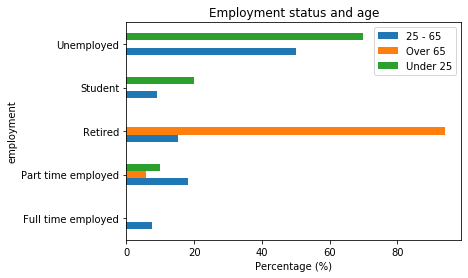

In [43]:
plotGroupBy(survey,'employment','age',title='Employment status and age',
                order=None,normalize=True)

current_living_arr,I am in an emergency shelter,I am staying with family and friends,I own my home,I pay full market rent,"I pay rent that is subsidized (e.g. rent sup, RGI, HA, PHB)","Other (e.g., I am homeless, I live in an institution). Please describe:"
employment,,,,,,
Full time employed,NaN,0.08,NaN,0.023810,0.0625,0.142857
Part time employed,NaN,0.12,NaN,0.214286,0.0625,0.142857
Retired,NaN,0.12,1.0,0.333333,0.3750,0.285714
Student,0.5,NaN,NaN,0.047619,0.3125,NaN
Unemployed,0.5,0.68,NaN,0.380952,0.1875,0.428571


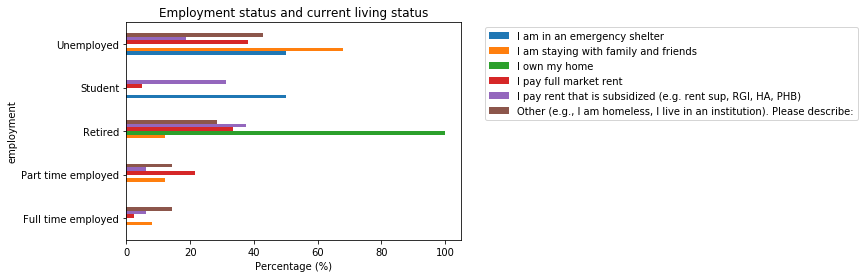

In [44]:
plotGroupBy(survey,'employment','current_living_arr',title='Employment status and current living status',
                order=None,normalize=True,legendXLoc=2.2)

### Current Living Status

I pay full market rent                                                     44.680851
I am staying with family and friends                                       27.659574
I pay rent that is subsidized (e.g. rent sup, RGI, HA, PHB)                17.021277
Other (e.g., I am homeless, I live in an institution). Please describe:     7.446809
I am in an emergency shelter                                                2.127660
I own my home                                                               1.063830
Name: current_living_arr, dtype: float64


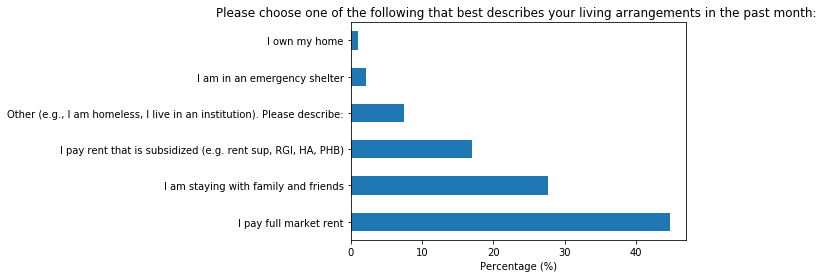

In [45]:
ax1 = plotResp(survey['current_living_arr'],questions,normalize=True)

### Reasons for moving

I can't afford where I live now                                            26.618705
It is only a temporary place to stay                                       23.021583
I need a larger place                                                      15.107914
I have concerns about the safety of my neighbourhood                       11.510791
I need to be closer to work childcare or social/health support services     7.913669
My place is in need of repair                                               7.913669
I need a modified unit because of disability. Please describe:              6.474820
I'm being evicted.                                                          1.438849
dtype: float64


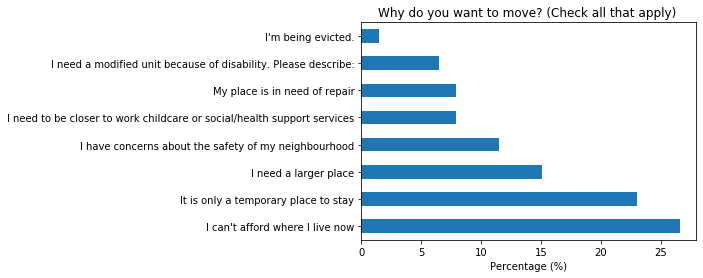

In [46]:
ax2 = plotResp(survey['why_move'],questions,normalize=True)

### Other variables by reason to move

In [47]:
# current living arrangement names
labels = ax1.get_yticklabels() # Get locations and labels
livingNames = [label.get_text() for label in labels]

# why move names
labels = ax2.get_yticklabels() # Get locations and labels
whyMoveNames = [label.get_text() for label in labels]

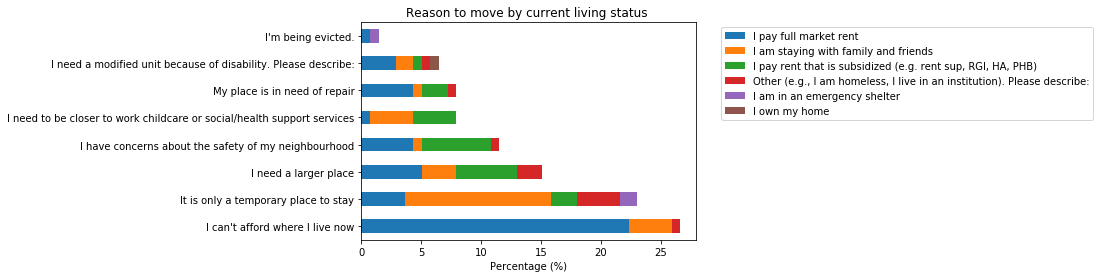

In [48]:
data = plotGroupByWhyMove(survey,'current_living_arr',whyMoveNames,livingNames,
                   title='Reason to move by current living status ',transpose=False)

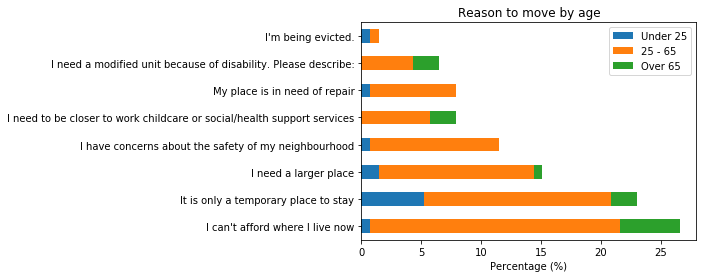

In [73]:
data = plotGroupByWhyMove(survey,'age',whyMoveNames,survey.age.dropna().unique().tolist(),
                   title='Reason to move by age',transpose=False,legendXLoc=1)

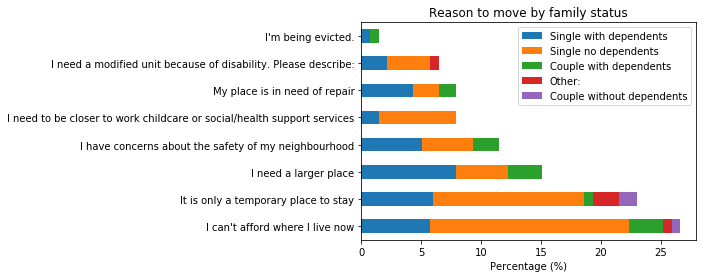

In [50]:
data = plotGroupByWhyMove(survey,'fam_status',whyMoveNames,survey.fam_status.dropna().unique().tolist(),
                   title='Reason to move by family status',transpose=False,legendXLoc=1)

In [51]:
def recodeMental(row):
    "Return a Pandas row object with modified mental health data"
    
    if (row.mental_health == 'A great deal') | (row.mental_health == 'A lot'):
        row.mental_health = 'Severe'
    elif (row.mental_health == 'A moderate amount') | (row.mental_health == 'A little'):
        row.mental_health = 'Moderate'
    elif row.mental_health == 'Not at all':
        row.mental_health = 'None'
    else:
        row.mental_health = row.mental_health
        
    return row.mental_health
            
survey['mod_mental'] = survey.apply(recodeMental,axis='columns')

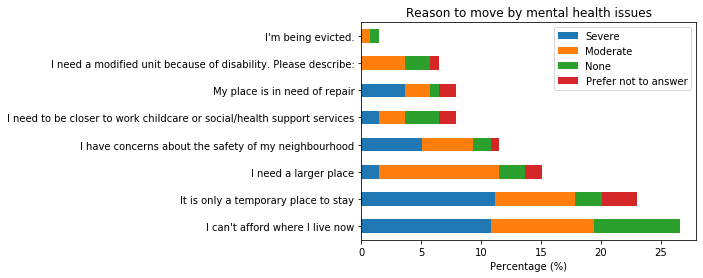

In [52]:
data = plotGroupByWhyMove(survey,'mod_mental',whyMoveNames,['Severe','Moderate','None','Prefer not to answer'],
                   title='Reason to move by mental health issues',transpose=False,legendXLoc=1)

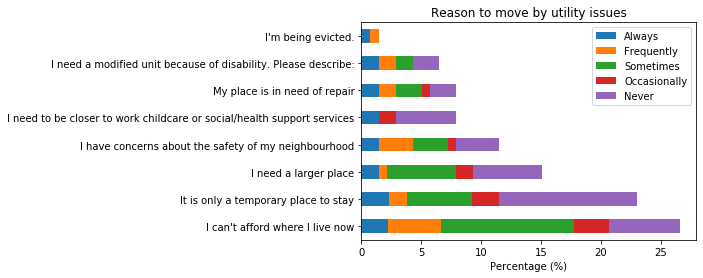

In [53]:
data = plotGroupByWhyMove(survey,'utilities',whyMoveNames,['Always','Frequently','Sometimes','Occasionally','Never'],
                   title='Reason to move by utility issues',transpose=False,legendXLoc=1)

## Waitlist Status

### Number of Times Applied for Waitlist status

4+     9.278351
3      8.247423
2     30.927835
1     51.546392
Name: num_applied, dtype: float64


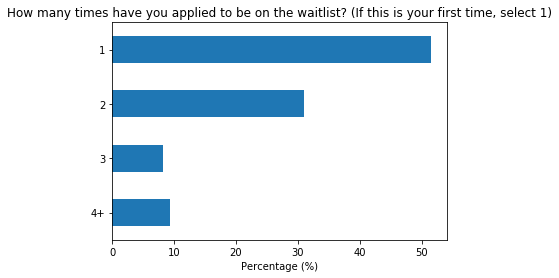

In [54]:
waitlistOrder = ['4+',3,2,1]
plotResp(survey['num_applied'],questions,order=waitlistOrder,normalize=True)

employment,Full time employed,Part time employed,Retired,Student,Unemployed
num_applied,,,,,
1,0.083333,0.145833,0.229167,0.104167,0.437500
2,0.035714,0.142857,0.285714,0.071429,0.464286
3,NaN,NaN,0.625000,NaN,0.375000
4+,NaN,0.333333,0.222222,0.111111,0.333333


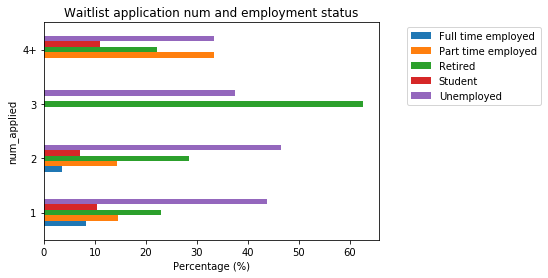

In [55]:
plotGroupBy(survey,'employment','num_applied',title='Waitlist application num and employment status',
                order=None,normalize=True,transpose=True,legendXLoc=1.5)

mental_health,Prefer not to answer,A great deal,A lot,A moderate amount,A little,Not at all
num_applied,,,,,,
1,0.062500,0.291667,0.062500,0.229167,0.125000,0.229167
2,0.035714,0.178571,0.142857,0.178571,0.321429,0.142857
3,0.125000,NaN,NaN,0.125000,0.125000,0.625000
4+,0.111111,0.111111,0.444444,0.111111,0.111111,0.111111


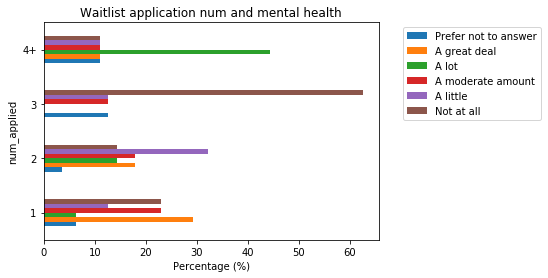

In [56]:
mentalOrder = ['Prefer not to answer','A great deal','A lot','A moderate amount',
              'A little','Not at all']
plotGroupBy(survey,'mental_health','num_applied',title='Waitlist application num and mental health',
                order=mentalOrder,normalize=True,transpose=True,
        legendXLoc=1.5)

age,25 - 65,Over 65,Under 25
num_applied,,,
1,0.729167,0.145833,0.125000
2,0.678571,0.214286,0.107143
3,0.375000,0.500000,0.125000
4+,1.000000,NaN,NaN


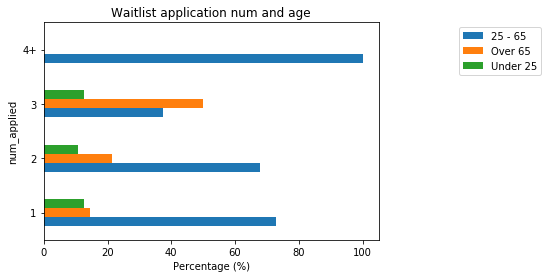

In [57]:
plotGroupBy(survey,'age','num_applied',title='Waitlist application num and age',
                order=None,normalize=True,transpose=True,legendXLoc=1.5)

income_stable,Always Stable,Always Unstable,Frequently Stable,Frequently Unstable,Sometimes Unstable
num_applied,,,,,
1,0.354167,0.104167,0.229167,0.104167,0.208333
2,0.464286,0.035714,0.285714,0.142857,0.071429
3,0.625000,NaN,0.125000,NaN,0.250000
4+,0.444444,0.222222,0.222222,0.111111,NaN


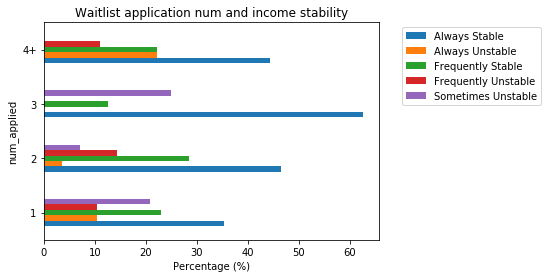

In [58]:
plotGroupBy(survey,'income_stable','num_applied',title='Waitlist application num and income stability',
                order=None,normalize=True,transpose=True,legendXLoc=1.5)

### Reason for applying multiple times

Other. Please describe:                                 64.444444
Missed annual check-in                                  24.444444
Became ineligible for the waitlist. Please describe:     8.888889
Missed annual check-in,Other. Please describe:           2.222222
Name: num_applied_explain, dtype: float64


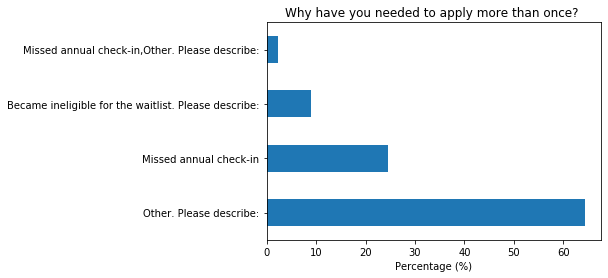

In [59]:
plotResp(survey['num_applied_explain'],questions,normalize=True)

### Applied to affordable housing options?

No              46.808511
I don't know    35.106383
Yes             18.085106
Name: private_housing, dtype: float64


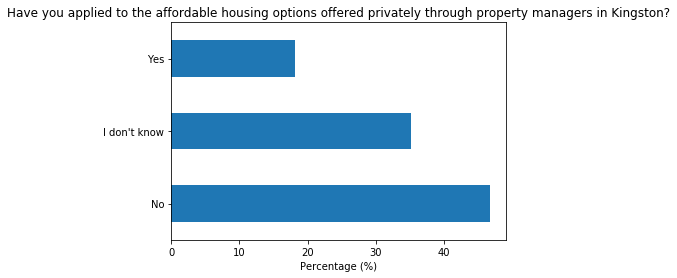

In [60]:
plotResp(survey['private_housing'],questions,normalize=True)

### Prefer to stay with rent subsidy

No     62.365591
Yes    37.634409
Name: subsidy, dtype: float64


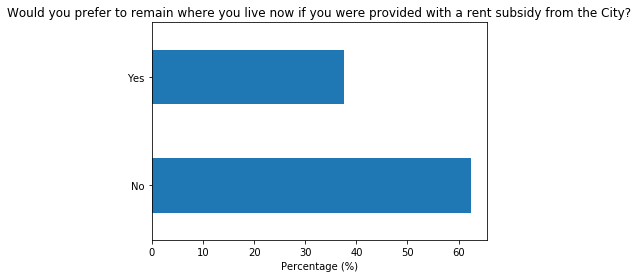

In [61]:
plotResp(survey['subsidy'],questions,normalize=True)

### Why do people want/not want the rent subsidy?

subsidy,No,Yes
current_living_arr,,
I am in an emergency shelter,0.034483,NaN
I am staying with family and friends,0.327586,0.200000
I own my home,0.017241,NaN
I pay full market rent,0.344828,0.628571
"I pay rent that is subsidized (e.g. rent sup, RGI, HA, PHB)",0.189655,0.142857
"Other (e.g., I am homeless, I live in an institution). Please describe:",0.086207,0.028571


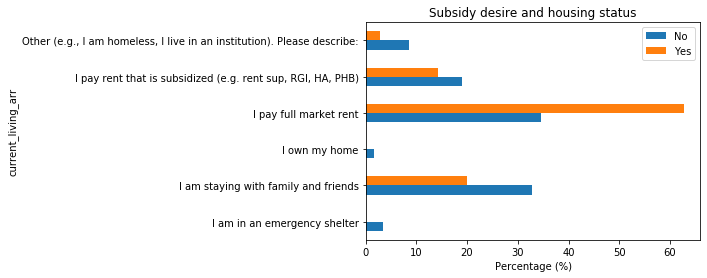

In [62]:
plotGroupBy(survey,'current_living_arr','subsidy',title='Subsidy desire and housing status',
                order=None,normalize=True)

Yes    52.380952
No     47.619048
Name: subsidy, dtype: float64


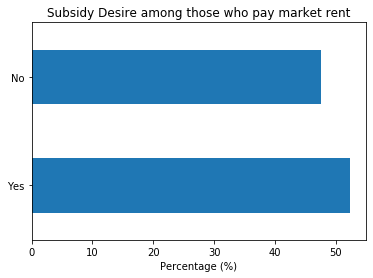

In [63]:
plotResp(survey.loc[(survey['current_living_arr']=='I pay full market rent')]['subsidy'],questions,normalize=True,
        title='Subsidy Desire among those who pay market rent')

I can't afford where I live now                                            47.826087
It is only a temporary place to stay                                       15.217391
I need a larger place                                                      13.043478
I need to be closer to work childcare or social/health support services     8.695652
I have concerns about the safety of my neighbourhood                        6.521739
I need a modified unit because of disability. Please describe:              4.347826
My place is in need of repair                                               4.347826
dtype: float64


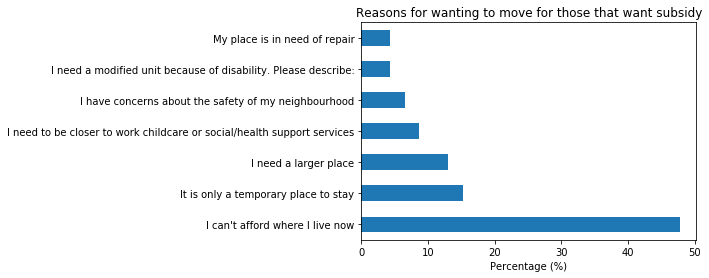

In [64]:
plotResp(survey.loc[(survey['subsidy']=='Yes')].why_move,questions,
         normalize=True,title='Reasons for wanting to move for those that want subsidy')

I can't afford where I live now                                            32.352941
I need a larger place                                                      14.705882
I have concerns about the safety of my neighbourhood                       14.705882
My place is in need of repair                                              14.705882
It is only a temporary place to stay                                       11.764706
I need a modified unit because of disability. Please describe:              5.882353
I'm being evicted.                                                          2.941176
I need to be closer to work childcare or social/health support services     2.941176
dtype: float64


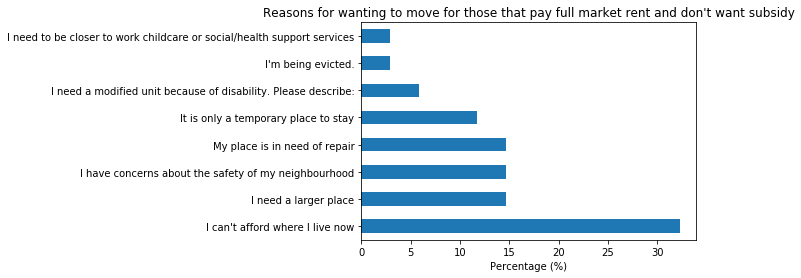

In [65]:
plotResp(survey.loc[(survey['subsidy']=='No') & 
    (survey['current_living_arr']=='I pay full market rent'
    )].why_move,questions,normalize=True,title='Reasons for wanting to move for those that pay full market rent'
    ' and don\'t want subsidy')

### How stable is your income?

Always Stable          41.935484
Frequently Stable      23.655914
Sometimes Unstable     15.053763
Frequently Unstable    10.752688
Always Unstable         8.602151
Name: income_stable, dtype: float64


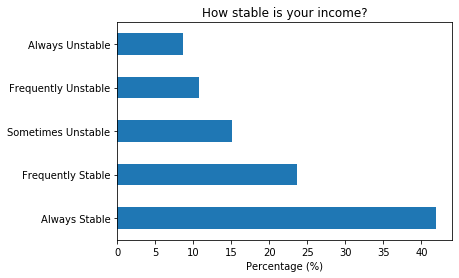

In [66]:
incomeOrder = ['Always Stable','Frequently Stable','Sometimes Unstable',
               'Frequently Unstable','Always Unstable']
plotResp(survey['income_stable'],questions,order=incomeOrder,normalize=True)

### Do you struggle to pay your utilities bill?

Always           9.890110
Frequently      10.989011
Sometimes       28.571429
Occasionally    12.087912
Never           38.461538
Name: utilities, dtype: float64


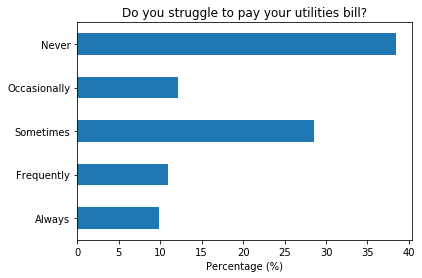

In [67]:
utilOrder = ['Always','Frequently','Sometimes','Occasionally','Never']
plotResp(survey['utilities'],questions,order=utilOrder,normalize=True)

### Is debt a reason why you are seeking a new residence?

Prefer not to answer     6.451613
A great deal            21.505376
A lot                   11.827957
A moderate amount       19.354839
A little                18.279570
Not at all              22.580645
Name: mental_health, dtype: float64


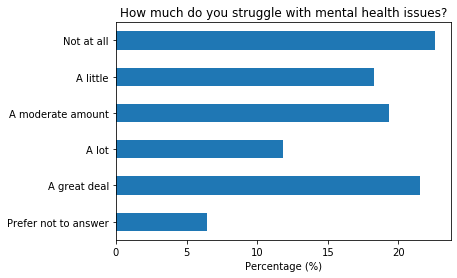

In [68]:
mentalOrder = ['Prefer not to answer','A great deal','A lot','A moderate amount',
              'A little','Not at all']
plotResp(survey['mental_health'],questions,order=mentalOrder,normalize=True)

### Mental health breakdown by gender

In [69]:
# Group by gender, convert to dataframe, and rename data col
data = survey.groupby(['gender']).mental_health.value_counts(normalize=True).reindex(mentalOrder,level='mental_health').to_frame(
).rename(columns={'mental_health':'resp'})
data.drop(index=["I don't identify within the gender binary",
                 "I prefer not to disclose information concerning my gender"],level='gender',inplace=True)

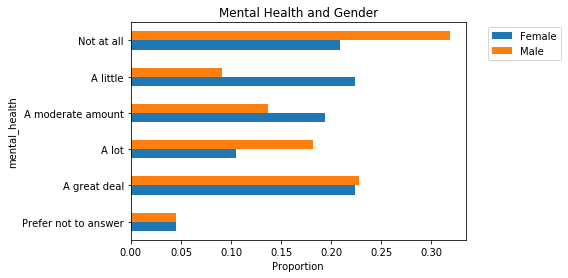

In [70]:
ax = pd.pivot_table(data, index = 'mental_health', columns = 'gender', 
    values = 'resp').plot(kind = 'barh',title='Mental Health and Gender')
plt.draw()
ax.set_xlabel('Proportion')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1)) # move legend to outside axes

### How much do you struggle with issues related to drinking or drug use?

Prefer not to answer     3.225806
A great deal             1.075269
A lot                         NaN
A moderate amount        5.376344
A little                 7.526882
Not at all              82.795699
Name: substance_use, dtype: float64


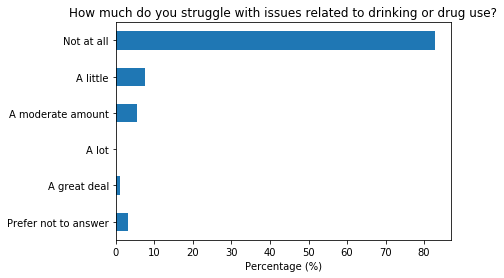

In [71]:
plotResp(survey['substance_use'],questions,order=mentalOrder,normalize=True)